<a href="https://colab.research.google.com/github/itsdivgithub/Healthcare_Domain_Classification/blob/main/S4_XLNET_UNBALANCED_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install sentencepiece
!pip install nlpaug
!pip install transformers
import nlpaug.augmenter.word as naw
from nlpaug.util import Action

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time

from torch.nn.utils import clip_grad_norm_


!pip install torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from transformers import XLNetForSequenceClassification, XLNetTokenizer, AdamW, get_linear_schedule_with_warmup

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.1 MB/s eta 0:00:00


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<ipython-input-4-6a56889911b6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
<ipython-input-4-6a56889911b6>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
<ipython-input-4-6a56889911b6>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
<ipython-input-4-6a56889911b6>:25: UserWarning: To copy construct from a tensor, it is recommended to use 

Epoch 1/20 - Train Loss: 3.1780 - Train Accuracy: 0.2221
Epoch 1/20 - Test Loss: 2.7075 - Test Accuracy: 0.2730
Epoch 2/20 - Train Loss: 2.5998 - Train Accuracy: 0.3085
Epoch 2/20 - Test Loss: 2.3184 - Test Accuracy: 0.3441
Epoch 3/20 - Train Loss: 2.2137 - Train Accuracy: 0.3540
Epoch 3/20 - Test Loss: 2.0170 - Test Accuracy: 0.3651
Epoch 4/20 - Train Loss: 1.9090 - Train Accuracy: 0.3859
Epoch 4/20 - Test Loss: 1.9378 - Test Accuracy: 0.3473
Epoch 5/20 - Train Loss: 1.6880 - Train Accuracy: 0.4045
Epoch 5/20 - Test Loss: 1.9183 - Test Accuracy: 0.3149
Epoch 6/20 - Train Loss: 1.5278 - Train Accuracy: 0.4432
Epoch 6/20 - Test Loss: 1.9315 - Test Accuracy: 0.2667
Epoch 7/20 - Train Loss: 1.4263 - Train Accuracy: 0.4508
Epoch 7/20 - Test Loss: 1.9795 - Test Accuracy: 0.2458
Epoch 8/20 - Train Loss: 1.3188 - Train Accuracy: 0.4696
Epoch 8/20 - Test Loss: 2.0537 - Test Accuracy: 0.2144
Early stopping at epoch 8


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total Training Time: 889.20 seconds
Total Prediction Time: 66.46 seconds
Precision: 0.2002
Recall: 0.2144
F1 Score: 0.2001


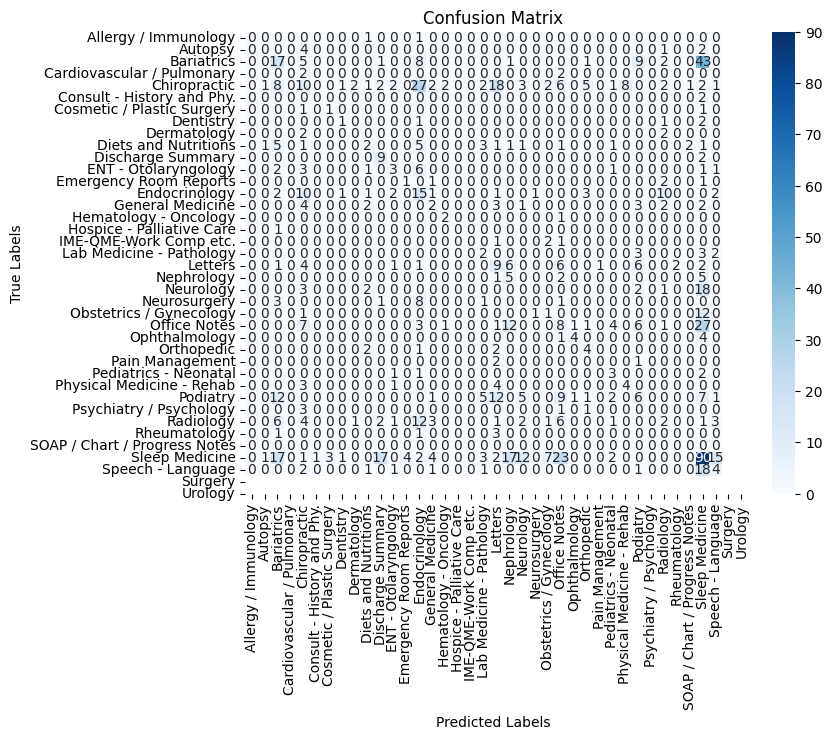

In [ ]:
# Step 1: Prepare the data
data = pd.read_csv('/content/drive/MyDrive/NLP_PROJECT/UNBALANCED_DATA/data.csv')
data = data.dropna()
X = data['description']
y = data['label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Fine-tune the XLNet model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=len(data['label'].unique()))
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')


# Tokenize the input data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors='pt')
# Convert the input data to tensors
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                             torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

# Define batch size and create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()

# Fine-tune the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 20


train_accuracy_list = []
train_loss_list = []
test_loss_list = []
test_accuracy_list  = []
epoch_list = []


# Learning rate scheduler
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * total_steps) #warmup for the first tex of total steps

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warmup_steps, num_training_steps = total_steps)

# Initialize variables for early stopping
best_test_accuracy = 0.0
best_epoch = 0
patience = 5
no_improvement_count = 0



tokenizer.save_pretrained('/content/drive/MyDrive/NLP_PROJECT/XLNET_TOKENIZER')

# Create the directory for model weights if it does not exist
model_directory = '/content/drive/MyDrive/NLP_PROJECT/XLNET_WEIGHTS'
os.makedirs(model_directory, exist_ok=True)

# Initialize variables for time measurement
total_training_time = 0.0
total_prediction_time = 0.0


for epoch in range(num_epochs):
    epoch_list.append(epoch+1)

    # Start time for training
    start_time_train = time.time()

    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)
        train_correct += (predicted_labels == labels).sum().item()
        train_total += labels.size(0)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()


    train_accuracy = train_correct / train_total
    train_loss = train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")

    # End time for training
    end_time_train = time.time()
    epoch_training_time = end_time_train - start_time_train
    total_training_time += epoch_training_time


    # After training loop
    model.eval()

    # Start time for prediction
    start_time_pred = time.time()

    test_loss = 0.0
    test_correct = 0
    test_total = 0



    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, predicted_labels = torch.max(logits, 1)
            test_correct += (predicted_labels == labels).sum().item()
            test_total += labels.size(0)

            test_loss += loss.item()


    test_accuracy = test_correct / test_total
    test_loss = test_loss / len(test_loader)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")


    # End time for prediction
    end_time_pred = time.time()
    epoch_prediction_time = end_time_pred - start_time_pred
    total_prediction_time += epoch_prediction_time


    # Check for early stopping condition
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        no_improvement_count = 0
        # Save the model weights and optimizer state dictionary for the best accuracy
        model_path = f'/content/drive/MyDrive/NLP_PROJECT/XLNET_WEIGHTS/best_model.pt'
        torch.save(model.state_dict(), model_path)
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break



# Calculate precision, recall, and F1 score
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)
        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Print total training and prediction times
print(f"Total Training Time: {total_training_time:.2f} seconds")
print(f"Total Prediction Time: {total_prediction_time:.2f} seconds")


print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

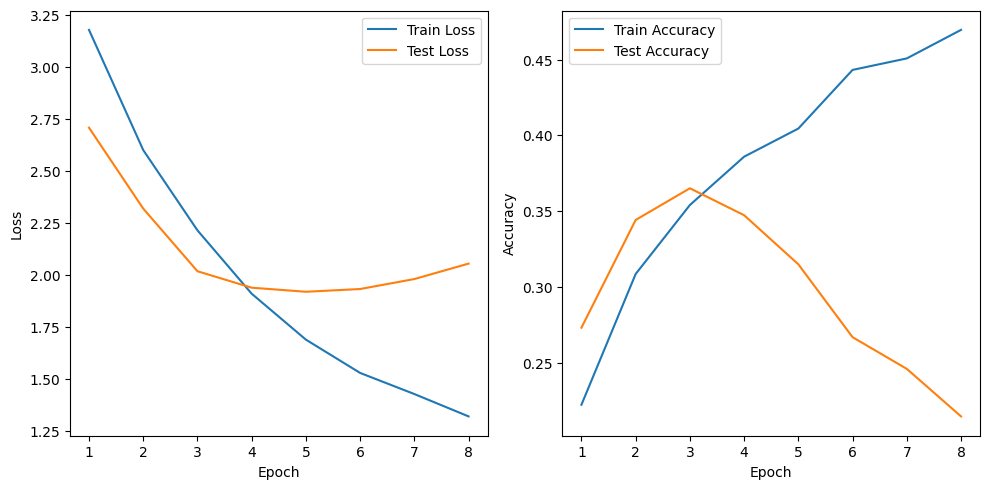

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

# Save the plots to a specific directory
plots_dir = '/content/drive/MyDrive/NLP Final Project/PLOTS'
os.makedirs(plots_dir, exist_ok=True)
plt.savefig(os.path.join(plots_dir, 'xlnet_loss_and_accuracy_curves.png'))
plt.show()